# Scaling up photometry preprocessing

This notebook shows how to scale up photometry preprocessing for many signals across many subjects. This will mostly involve usinng __for loops__ to look through our data using our previously developed preprocessing steps. This steps shown are: 

1. Looping through all regions recorded in one subject (JM1)

2. Turning the for loops into functions are work for all subjects 

The data used in this notebook were recorded from 10 differet regions (5 regions bilaterally) in 3 different animals during an IED procedure. 

In [28]:
# ===============================================
# Import essential modules
# ===============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize


%matplotlib inline 
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

# Import data and define functions

The first step is always importing the data. As our data gets more complex it's critical to have a clear understanding of it's structure. Using the __.head()__ function we'll take a peak of the structure of our GCaMP dataframe.

In [37]:
# change path to data folder
path = os.getcwd()
parent_dir = os.path.dirname(path)
data_dir = f"{parent_dir}/data"
os.chdir(data_dir)



# import data from .csv files
JM1_IED_415 = pd.read_csv('JM1 IED 410.csv') # Isosbestic
JM1_IED_470 = pd.read_csv('JM1 IED 470.csv') # GCaMP

# Get just the channel data
ISOS_raw = JM1_IED_415.iloc[:,3:] 
GCaMP_raw = JM1_IED_470.iloc[:,3:]

# Define variables for future use
fs = 30
regions = JM1_IED_415.columns[3:].astype(str)
time_seconds = np.arange(0, len(GCaMP_raw)/fs, 1/fs) # get time in seconds

# See the header (first 5 rows)
GCaMP_raw.head()


,Region0G,Region1G,Region2G,Region3G,Region4G,Region5G,Region6G,Region7G,Region8G,Region9G
0,0.038260,0.071127,0.029745,0.022701,0.055734,0.074728,0.061699,0.044038,0.010527,0.025369
1,0.039723,0.069604,0.029810,0.023406,0.057482,0.072493,0.061158,0.044078,0.012438,0.027212
2,0.036954,0.064503,0.026663,0.020717,0.055295,0.067635,0.057139,0.040671,0.010426,0.024757
3,0.038410,0.064069,0.027539,0.022020,0.057138,0.067599,0.057484,0.041578,0.012394,0.026572
4,0.037802,0.062498,0.026508,0.021528,0.056935,0.066262,0.056431,0.040970,0.012306,0.026819


Whereas in the last notebook we were dealing with a single array of data, here our __GCaMP_raw__ and __ISOS_raw__ dataframes are 2D matrices with column titles that tell us what region they correspond to. We can preprocess the signals one at a time by looping through the columns.

Let's start with reusing the preprocessing functions we made in the previous notebook. I have renamed something in these functions for clarity sake. 

In [38]:
def denoise(raw, time_seconds, fs):
    '''This function denoises GCaMP or ISOS signals
    with a median ad lowpass filter. Then it fits a 4th order 
    polyonmial to the data subtracts the polyomial fit from the
    raw data.'''

    # Median and lowpass filter with filtfilt
    denoised_med = medfilt(raw, kernel_size=5)

    b,a = butter(2, 10, btype='low', fs=fs)
    denoised = filtfilt(b,a, denoised_med)

    # Fit 4th order polynomial to GCaMP signal and sutract
    coefs = np.polyfit(time_seconds, denoised, deg=4)
    polyfit_data = np.polyval(coefs, time_seconds)

    debleached = denoised - polyfit_data
    
    return debleached, denoised

def correct_motion(GCaMP_debleached, ISOS_debleached):
    '''This function takes preprocessed GCaMP and Isosbestic
    sigals and finds the linear fit, then estimates the 
    motion correction and substracts it from GCaMP.'''
    
    # find linear fit
    slope, intercept, r_value, p_value, std_err = linregress(x=ISOS_debleached, y=GCaMP_debleached)
    
    # estimate motion correction and subtract
    GCaMP_est_motion = intercept + slope * ISOS_debleached
    GCaMP_corrected = GCaMP_debleached - GCaMP_est_motion
    
    return GCaMP_corrected

def deltaF_F(GCaMP_corrected, denoised, fs):
    '''This function calculates the dF/F using the 
    denoised data and the motion corrected data.'''
    
    # Low pass denoised data to get baseline fluorescence
    b,a = butter(2, 0.001, btype='low', fs=fs)
    baseline_fluorescence = filtfilt(b,a, denoised, padtype='even')
    
    # Divide Delta F (motion corrected) by the baseline fluorescence
    GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence
    
    return GCaMP_dF_F

Next, we'll create a single function to call all of the above preprocessing functions. This will just make our code cleaner.

In [39]:
def preprocess(GCaMP_raw, ISOS_raw, time_seconds, fs):
    '''This function calls the above functions to create a one-functio
    processing step.'''
    
    # Denoise and debleach
    GCaMP_debleached, GCaMP_denoised = denoise(GCaMP_raw, time_seconds, fs)
    ISOS_debleached, x = denoise(ISOS_raw, time_seconds, fs)

    # Motion correction
    GCaMP_corrected = correct_motion(GCaMP_debleached, ISOS_debleached)

    # Delta F / F
    GCaMP_dF_F = deltaF_F(GCaMP_corrected, GCaMP_denoised, fs)
    
    return GCaMP_dF_F


# Looping through all signals for one animal

It's always best to start small when developing code, so we'll first use a for loop to simply loop through all 10 regions in one animal. 

We'll also want to plot the before and after so we have idea if the preprocessing steps were successful or inadvertently distorded the data, so we'll loop through the plots as well.

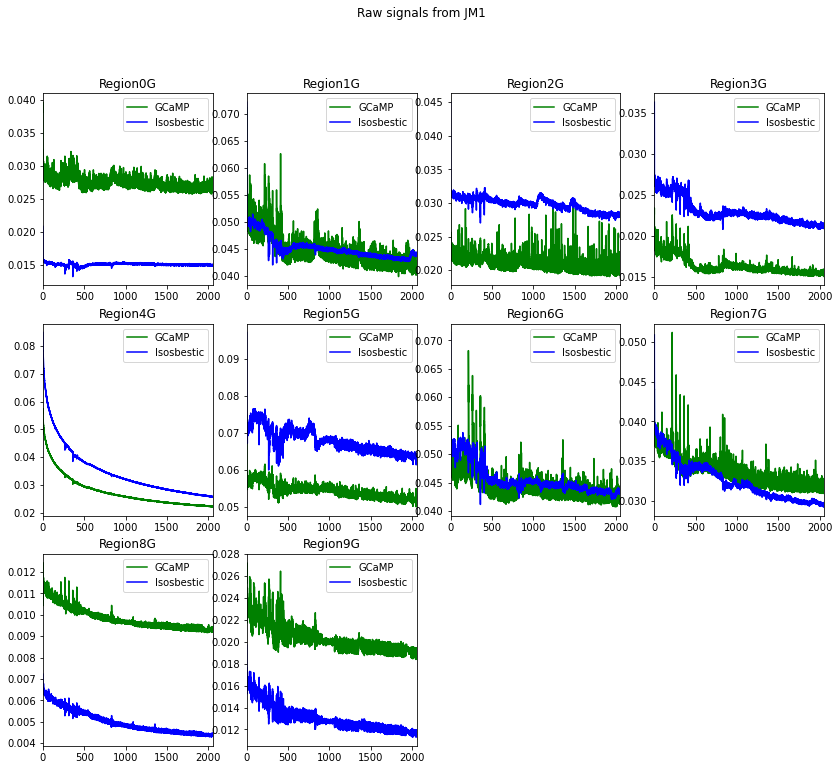

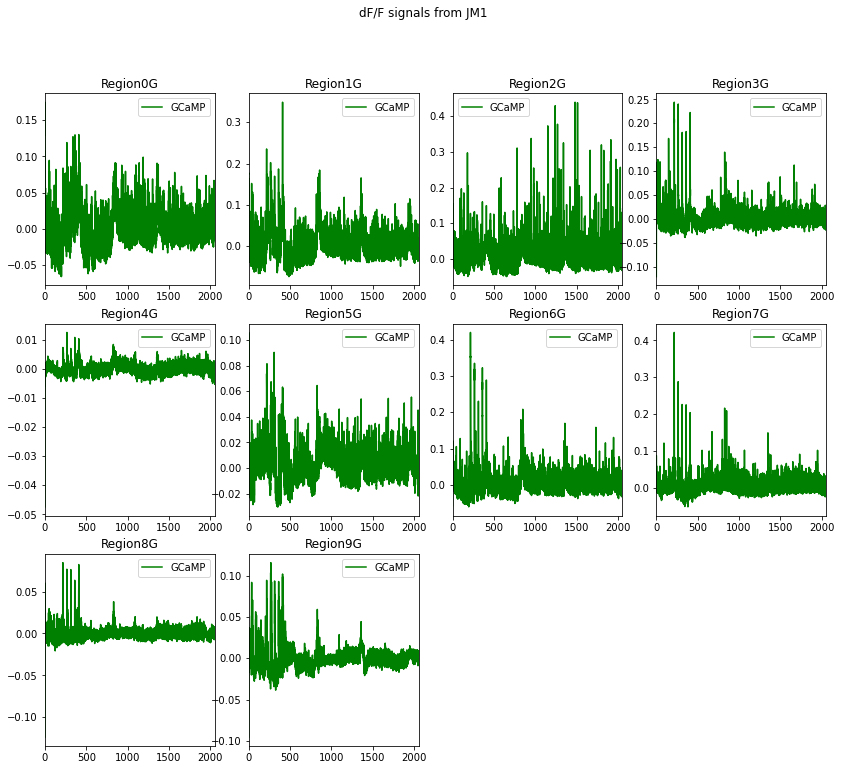

In [40]:

JM1_dF_F = np.zeros(GCaMP_raw.shape)  # initiatize a matrix of zeros
for i in range(0,len(GCaMP_raw.columns)): # loop through columns
    
    # preprocess each column and save to initialized matrix
    JM1_dF_F[:,i] = preprocess(GCaMP_raw.iloc[:,i], ISOS_raw.iloc[:,i], time_seconds, fs=fs)

    
# Plotting
plt.figure()
for i in range(0,len(regions)):
    plt.subplot(3,4,i+1)
    plt.plot(time_seconds,GCaMP_raw.iloc[:,i], 'g', label='GCaMP')
    plt.plot(time_seconds,ISOS_raw.iloc[:,i], 'b', label='Isosbestic')
    plt.title(regions[i])
    plt.suptitle('Raw signals from JM1')
    plt.legend()
    
plt.figure()
for i in range(0,len(regions)):
    plt.subplot(3,4,i+1)
    plt.plot(time_seconds,JM1_dF_F[:,i], 'g', label='GCaMP')
    plt.title(regions[i])
    plt.suptitle('dF/F signals from JM1')
    plt.legend()

As you can see, we were able to preprocess all 10 regions with only 3 total lines of code. 

# Scaling to many subjects

First import all the desired data.

In [41]:
# import data from .csv files
JM1_IED_415 = pd.read_csv('JM1 IED 410.csv') # Isosbestic
JM1_IED_470 = pd.read_csv('JM1 IED 470.csv') # GCaMP

# import data from .csv files
JM2_IED_415 = pd.read_csv('JM2 IED 410.csv') # Isosbestic
JM2_IED_470 = pd.read_csv('JM2 IED 470.csv') # GCaMP

# import data from .csv files
JM3_IED_415 = pd.read_csv('JM3 IED 410.csv') # Isosbestic
JM3_IED_470 = pd.read_csv('JM3 IED 470.csv') # GCaMP


# Get just the channel data
JM1_ISOS_raw = JM1_IED_415.iloc[:,3:] 
JM1_GCaMP_raw = JM1_IED_470.iloc[:,3:]

# Get just the channel data
JM2_ISOS_raw = JM2_IED_415.iloc[:,3:] 
JM2_GCaMP_raw = JM2_IED_470.iloc[:,3:]

# Get just the channel data
JM3_ISOS_raw = JM3_IED_415.iloc[:,3:] 
JM3_GCaMP_raw = JM3_IED_470.iloc[:,3:]

Although it's possible to create a for loop to loop through subjects, this gets tricky for a few reasons. So instead we'll turn our previous preprocess and plotting loops into their own functions. This should allow for preprocessing and plotting all signals with one subject to be acheived with a single line of code.

Of note: I found that not all 415 and 470 signals were the same length due to being collected in an interleaved fashion. This commonly resulted in one signal having just one more data point than the other. To fix this I made the __make_same_length__ functio which compares the 415 ad 470 lengths, then corrects if they're not even by removing the extra data points on the longer signal. 

In [42]:
def make_same_length(GCaMP_raw, ISOS_raw):
    
    # Get lengths
    GCaMP_len = len(GCaMP_raw)
    ISOS_len = len(ISOS_raw)
    
    # Remove overextending data points
    if GCaMP_len > ISOS_len:
        GCaMP_raw = GCaMP_raw.iloc[:ISOS_len,:]
        
    elif ISOS_len > GCaMP_len:
        ISOS_raw = ISOS_raw.iloc[:GCaMP_len,:]
        
    return GCaMP_raw, ISOS_raw


def preprocess_many(GCaMP_raw, ISOS_raw, fs):
    '''Turns out for loop from above into a function.'''
    
    # Make same length
    GCaMP_raw, ISOS_raw = make_same_length(GCaMP_raw, ISOS_raw)
    
    # Get time (different for each subject)
    time_seconds = np.arange(0, len(ISOS_raw)/fs, 1/fs) 

    # In case time ends up longer due to ???
    if len(time_seconds) > len(GCaMP_raw):
        time_seconds = time_seconds[:len(GCaMP_raw)]
    
    # Loop through regionns
    dF_F = np.zeros(GCaMP_raw.shape)
    for i in range(0,len(GCaMP_raw.columns)):
        dF_F[:,i] = preprocess(GCaMP_raw.iloc[:,i], ISOS_raw.iloc[:,i], time_seconds, fs=fs)
            
    return dF_F

def plot_many(dF_F, GCaMP_raw, ISOS_raw, sub_name):
    
    # Make same length
    GCaMP_raw, ISOS_raw = make_same_length(GCaMP_raw, ISOS_raw)
    
    # Get time (different for each subject)
    time_seconds = np.arange(0, len(ISOS_raw)/fs, 1/fs) 

    # In case time ends up longer due to ???
    if len(time_seconds) > len(GCaMP_raw):
        time_seconds = time_seconds[:len(GCaMP_raw)]
    
    plt.figure()
    for i in range(0,len(GCaMP_raw.columns)):
        plt.subplot(3,4,i+1)
        plt.plot(time_seconds,GCaMP_raw.iloc[:,i], 'g', label='GCaMP')
        plt.plot(time_seconds,ISOS_raw.iloc[:,i], 'b', label='Isosbestic')
        plt.title(regions[i])
        plt.suptitle('Raw signals from ' + sub_name)
        plt.legend()

    plt.figure()
    for i in range(0,len(GCaMP_raw.columns)):
        plt.subplot(3,4,i+1)
        plt.plot(time_seconds,dF_F[:,i], 'g', label='GCaMP')
        plt.title(regions[i])
        plt.suptitle('dF/F signals from ' + sub_name)
        plt.legend()

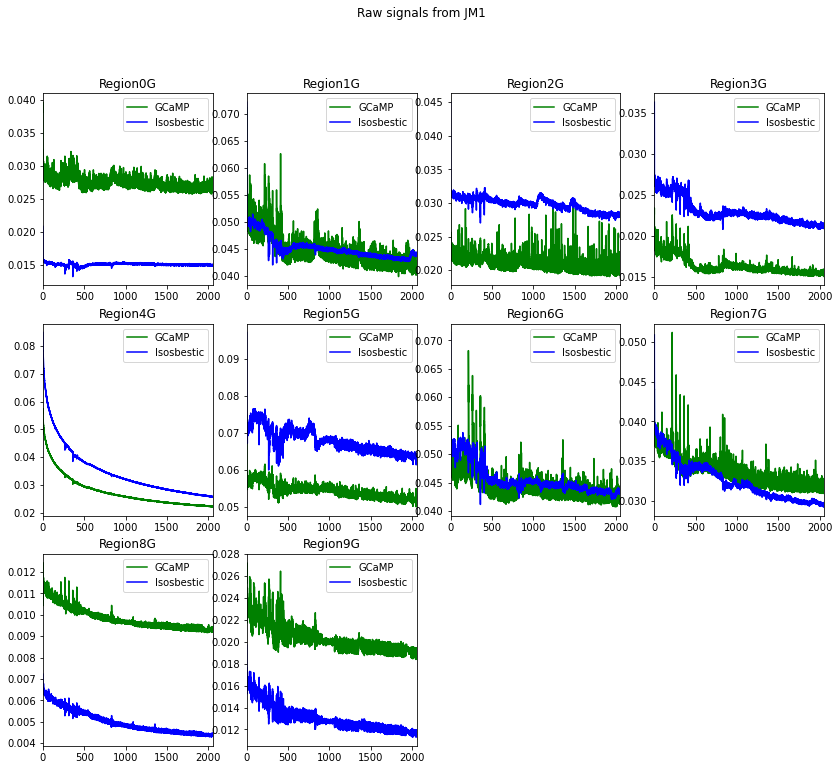

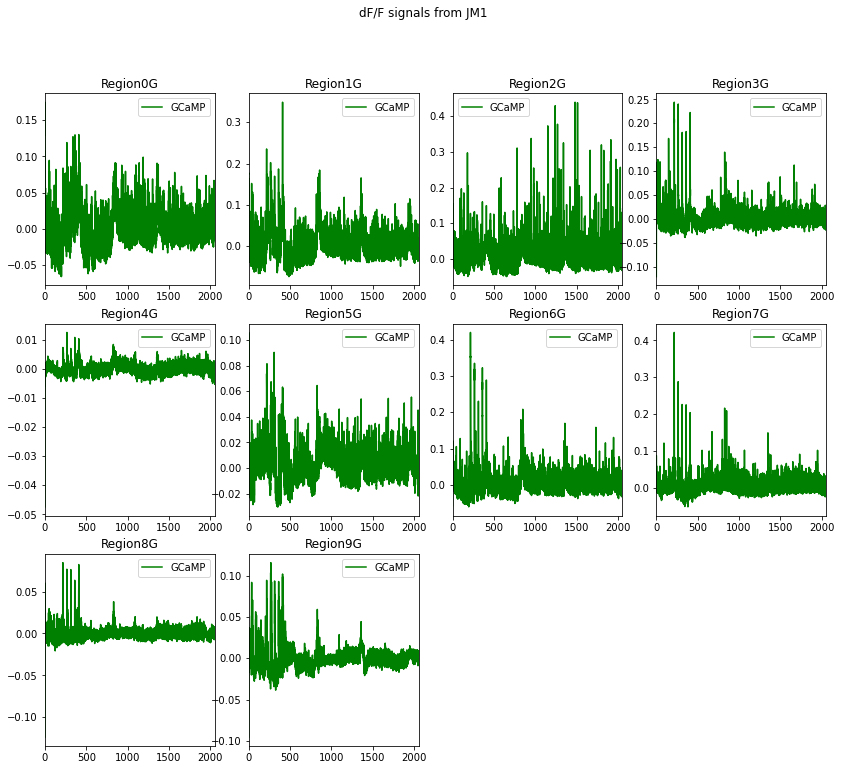

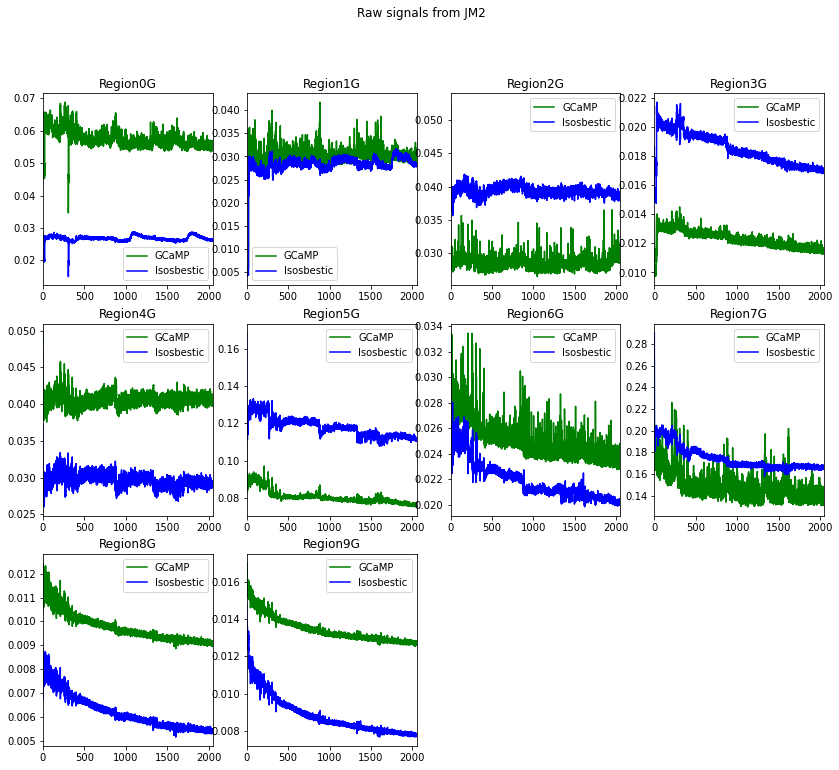

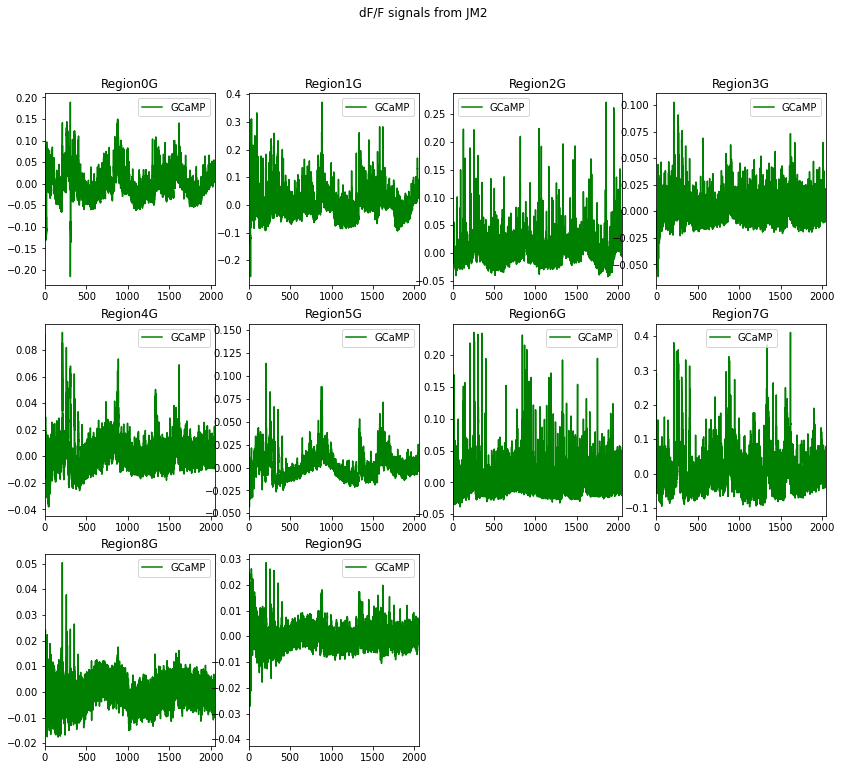

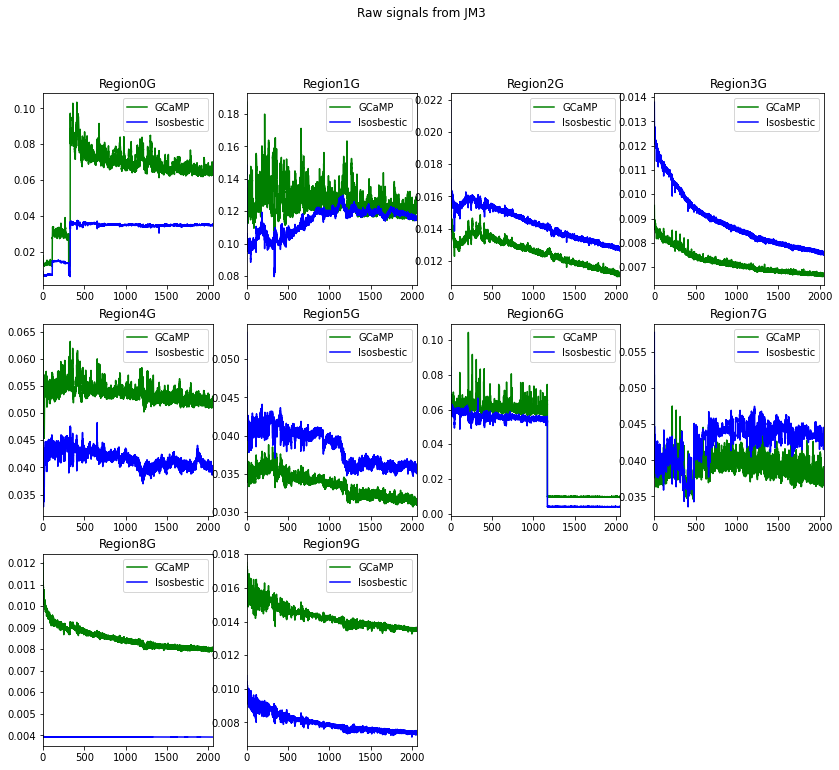

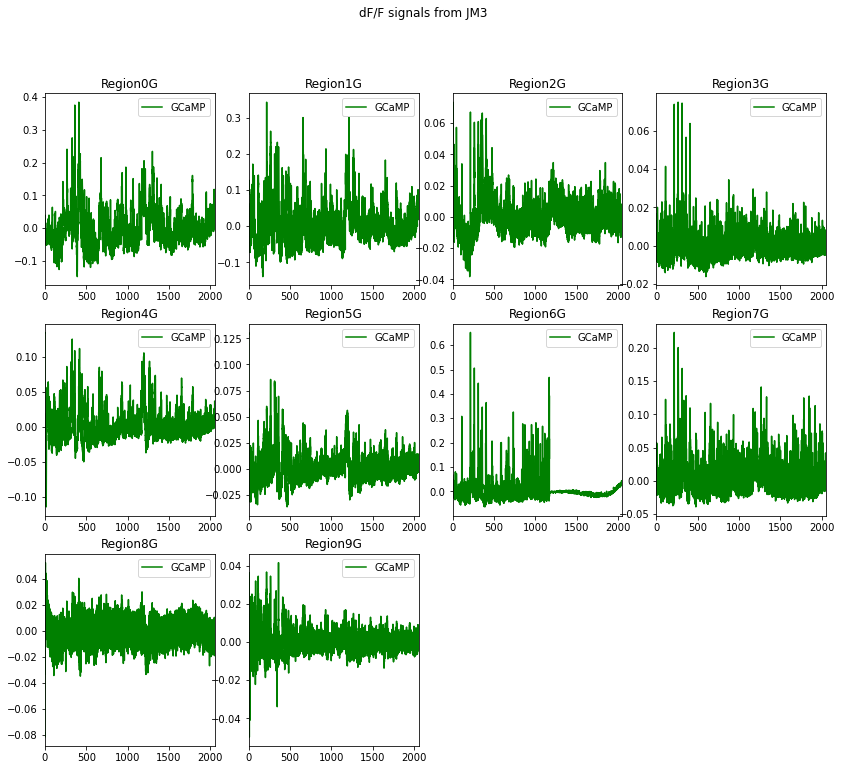

In [43]:
# Create a single 'list' containing all three subjects data

JM1_dF_F = preprocess_many(JM1_GCaMP_raw, JM1_ISOS_raw, fs)
JM2_dF_F = preprocess_many(JM2_GCaMP_raw, JM2_ISOS_raw, fs)
JM3_dF_F = preprocess_many(JM3_GCaMP_raw, JM3_ISOS_raw, fs)
 
plot_many(JM1_dF_F, JM1_GCaMP_raw, JM1_ISOS_raw, sub_name='JM1')
plot_many(JM2_dF_F, JM2_GCaMP_raw, JM2_ISOS_raw, sub_name='JM2')
plot_many(JM3_dF_F, JM3_GCaMP_raw, JM3_ISOS_raw, sub_name='JM3')

In this notebook we show how to use for loops and functions to quickly speed up preprocessing steps. We managed to prepocess 30 signals in just three lines of code, and also generate 60 plots in just 3 more lines of code. 